In [1]:
import sqlalchemy as sq
import pandas as pd

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
engine = sq.create_engine("sqlite:///data/covid_db.sqlite")
cnx = engine.connect()

In [3]:
meta = sq.MetaData()
meta.reflect(bind=engine)

In [4]:
meta.tables.keys()

dict_keys(['covid_states', 'covid_world'])

In [25]:
df = pd.read_sql('covid_world',con=cnx)
df['date'] = pd.to_datetime(df['date'])

In [30]:
vax_cols = [col for col in df.columns if 'vacc' in col]
cols = ['iso_code', 'continent', 'location', 'date'] + vax_cols

In [31]:
vax_cols

['total_vaccinations',
 'people_vaccinated',
 'people_fully_vaccinated',
 'new_vaccinations',
 'new_vaccinations_smoothed',
 'total_vaccinations_per_hundred',
 'people_vaccinated_per_hundred',
 'people_fully_vaccinated_per_hundred',
 'new_vaccinations_smoothed_per_million']

In [35]:
new_name = {
     'people_vaccinated':'one_dose_vaccinated',
     'people_fully_vaccinated':'all_doses_vaccinated',
     'new_vaccinations':'new_doses_administered',
     'new_vaccinations_smoothed':'new_doses_administered_smoothed',
     'people_vaccinated_per_hundred':'one_dose_vaccinated_per_hundred',
     'people_fully_vaccinated_per_hundred':'all_doses_vaccinated_per_hundred',
     'new_vaccinations_smoothed_per_million':'new_doses_administered_smoothed_per_million'
}

[Source](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv) for what the columns represent

In [36]:
vax_df = df[cols]
vax_df = vax_df.rename(new_name, axis=1)

In [37]:
small_df = vax_df[(vax_df['location']=='United States') |
                  (vax_df['location']=='Canada') |
                  (vax_df['location']=='Hungary')
                 ]

<AxesSubplot:xlabel='date', ylabel='one_dose_vaccinated_per_hundred'>

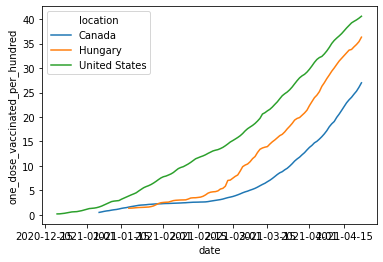

In [41]:
sns.lineplot(x='date',y='one_dose_vaccinated_per_hundred', 
             data=small_df, 
             hue='location')